# Open and Write Files


Let's open a file 'data/hsimple.root' and plot histograms from it


In [8]:
TFile inputfile("data/hsimple.root");  
inputfile.ls();

TFile**		data/hsimple.root	Demo ROOT file with histograms
 TFile*		data/hsimple.root	Demo ROOT file with histograms
  KEY: TH1F	hpx;1	This is the px distribution
  KEY: TH2F	hpxpy;1	py vs px
  KEY: TProfile	hprof;1	Profile of pz versus px
  KEY: TNtuple	ntuple;1	Demo ntuple


In [17]:
%jsroot on

In [18]:

// Get the histograms and the profile from the file
auto hpx = (TH1F*)inputfile.Get("hpx"); // 
auto hpxpy = (TH2F*)inputfile.Get("hpxpy");
auto hprof = (TProfile*)inputfile.Get("hprof");

// Create a canvas and divide it
TCanvas *can = new TCanvas("can","A Simple Graph Example",1200,500);
can->Divide(3,1); // 3 columns, 1 row

can->cd(1);
hpx->Draw();

can->cd(2);
hpxpy->Draw("colz");

can->cd(3);
hprof->Draw();
can->Draw();

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can


# Trees


In [16]:
TTree *tree = (TTree*)inputfile.Get("ntuple");
cout << "Number of entries in the tree: " << tree->GetEntries() << endl;
tree->Show(0);
tree->Show(20);

Number of entries in the tree: 25000
======> EVENT:0
 px              = 0.0194095
 py              = 0.0118255
 pz              = 0.000516569
 random          = 0.282618
 i               = 0
======> EVENT:20
 px              = -0.127767
 py              = -1.84029
 pz              = 3.40299
 random          = 0.740788
 i               = 20


In [ ]:
//Many ways to access the data in the tree

//1. Using the TTree::Draw method
tree->Draw("px");
tree->Draw("px","py>0");
tree->Draw("px:py","pz>0","colz");

//2. Using the TTree::Scan method
tree->Scan("px:py:pz");

//3. Using the TTree::GetEntry method
Float_t px, py, pz;
tree->SetBranchAddress("px", &px);
tree->SetBranchAddress("py", &py);
tree->SetBranchAddress("pz", &pz);

for (int i=0; i<tree->GetEntries(); i++) {
    tree->GetEntry(i);
    cout << "px: " << px << " py: " << py << " pz: " << pz << endl;
}

// TH1F h("xysum", "XY Sum;The Sum;Number of Entries", 64, -10, 10);
// ntuple->Draw("px + py >> xysum", "abs(pz)<2");
// h.Draw();
// c1->Draw()


# RDataFrames

In [1]:
auto ntupleName = "tree1";
auto fileName = "data/experiment.root";
ROOT::RDataFrame dataframe(ntupleName, fileName);


In [2]:
dataframe.Display()->Print();

+-----+-----------+----------+-------+------------+-----------+----------+-----------+
| Row | chi2      | ebeam    | event | px         | py        | pz       | zv        | 
+-----+-----------+----------+-------+------------+-----------+----------+-----------+
| 0   | 0.940583f | 150.140f | 0     | 14.3336f   | -4.02104f | 143.544f | 22.2641f  | 
+-----+-----------+----------+-------+------------+-----------+----------+-----------+
| 1   | 1.02056f  | 149.786f | 1     | 0.0509291f | -1.37331f | 148.600f | 0.614076f | 
+-----+-----------+----------+-------+------------+-----------+----------+-----------+
| 2   | 0.893446f | 150.162f | 2     | 4.00793f   | 3.88983f  | 145.688f | 16.5690f  | 
+-----+-----------+----------+-------+------------+-----------+----------+-----------+
| 3   | 1.02172f  | 150.142f | 3     | 1.45592f   | 4.66344f  | 146.706f | 11.4663f  | 
+-----+-----------+----------+-------+------------+-----------+----------+-----------+
| 4   | 0.854095f | 149.942f | 4     |

In [ ]:
auto hist2dim = dataframe.Histo2D("totalEnergy","muonEnergy",100,0,100,100,0,100);

In [ ]:
dataframe.Display()->Print()

In [ ]:
definept = dataframe.Define("pt","TMath::Sqrt(TMath::Power(px,2) + TMath::Power(py,2))");
definept.Display()->Print();

In [3]:
auto pzcut = dataframe.Filter("pz < 145").Histo1D("pz");

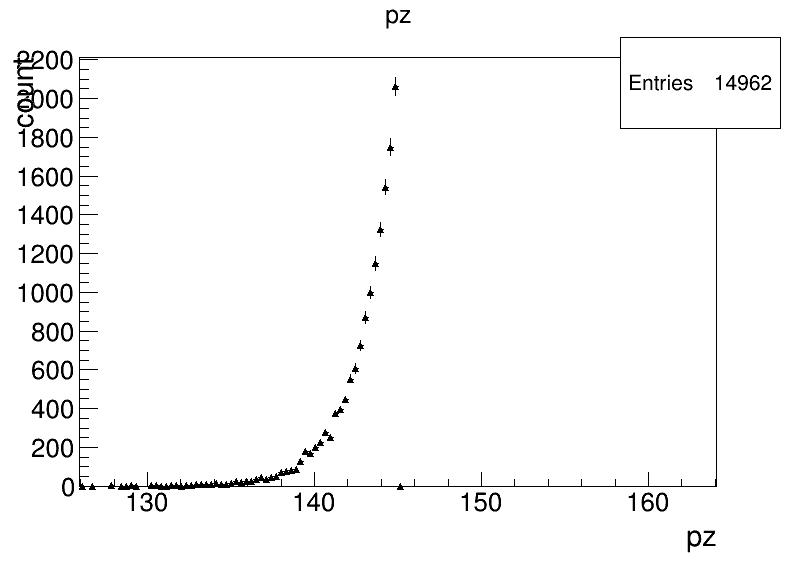

In [5]:
pzcut->Draw();

gPad->Draw();

In [ ]:
pzcut_hist->Draw();

In [ ]:
pzcut_hist->Draw();

In [8]:
hist2dim = dataframe.Histo2D({"hist2dim", "ebeam vs px", 100, 149, 151, 100, -20, 20},"ebeam","px");

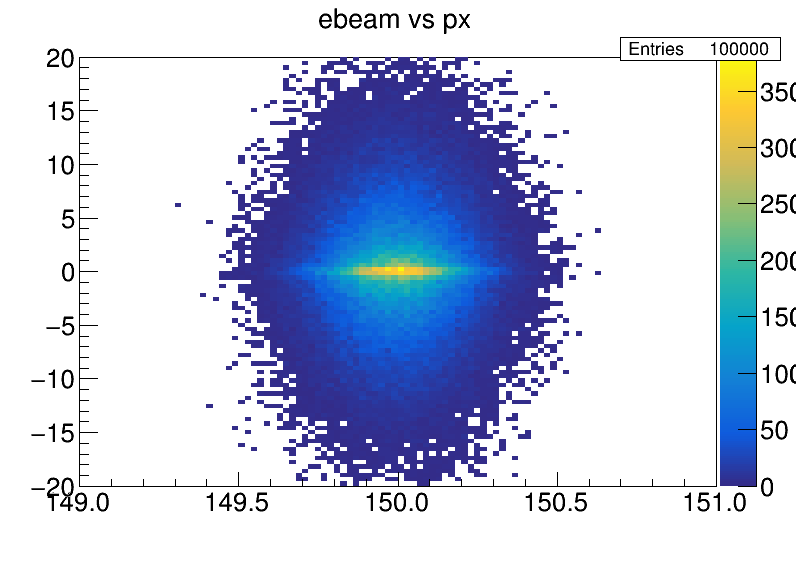

In [10]:
hist2dim -> Draw("colz");
gPad->Draw();